# Extract focal regions from human performance

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import sys

sys.path.append('../src')

from Config.config import PATHS

import warnings
warnings.filterwarnings("ignore")

In [2]:
from Utils.utils import GetMeasurements
from Utils.indices import AlternationIndex
from Classes.focal_regions import SetFocalRegions, FocalRegion

In [10]:
# Load data
file_name = PATHS['human_data']/'all_data.csv'
data = pd.read_csv(file_name)
data.drop(columns=['timeup', 'time', 'date'], inplace=True)
data['model'] = data.apply(lambda row: f"{row['room']}_{row['num_players']}_{row['threshold']}", axis=1)

# Compute measurements and alternation index
gm = GetMeasurements(data, ['bounded_efficiency', 'inequality'])
df = gm.get_measurements()

priority = 'mlp'
idx = AlternationIndex.from_file(priority=priority)

if priority == 'cnn':
    df['category'] = idx.classify(data)
    df['alternation_idx'] = idx(data)
else:
    df['category'] = idx.classify(df)
    df['alternation_idx'] = idx(df)

df = df[df['bounded_efficiency'] > 0.7]
df


,model,treatment,threshold,num_players,room,bounded_efficiency,inequality,category,alternation_idx
11,14_5_0.8,upwards,0.800000,5,14,0.750000,0.233364,mixed,1.067711e-15
14,15_4_0.75,upwards,0.750000,4,15,0.977011,0.270604,mixed,1.858561e-22
27,25_4_0.25,downwards,0.250000,4,25,1.000000,0.500000,segmentation,9.076210e-42
39,30_3_0.3333333333333333,downwards,0.333333,3,30,0.711111,0.078042,random,1.046002e-01
46,32_7_1.0,upwards,1.000000,7,32,0.980296,0.039100,mixed,5.461861e-02
51,34_3_0.6666666666666666,upwards,0.666667,3,34,0.722222,0.388306,segmentation,6.847862e-29
57,37_7_1.0,upwards,1.000000,7,37,0.926108,0.180751,mixed,8.247030e-14
78,Grupo-0001_2_0.5,score + grid,0.500000,2,Grupo-0001,1.000000,0.000000,alternation,9.987193e-01
83,Grupo-0006_2_0.5,score + grid,0.500000,2,Grupo-0006,1.000000,0.000000,alternation,9.987193e-01
91,Grupo-0014_2_0.5,only score,0.500000,2,Grupo-0014,0.740000,0.042426,alternation,8.090679e-01


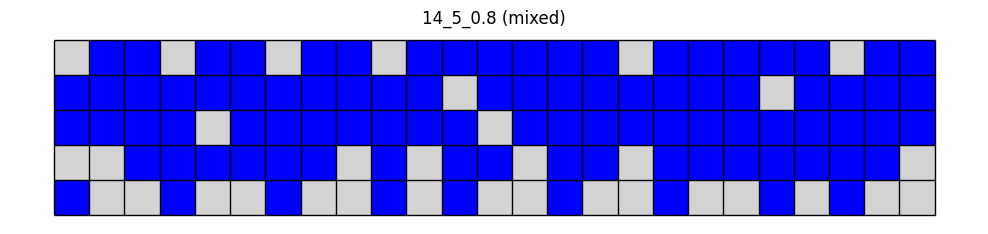

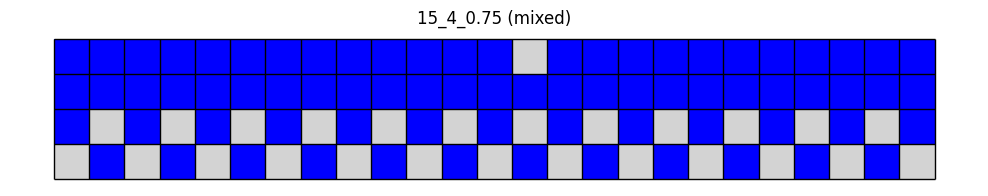

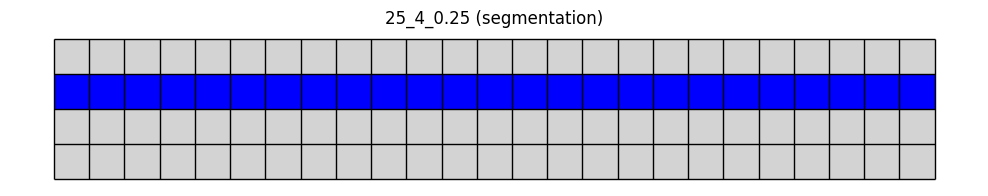

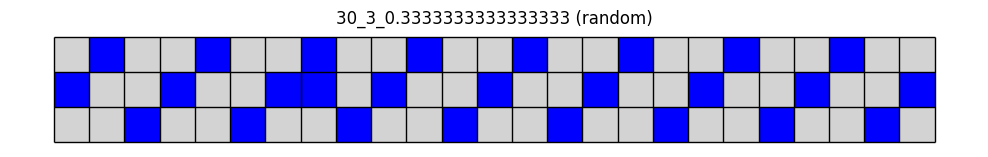

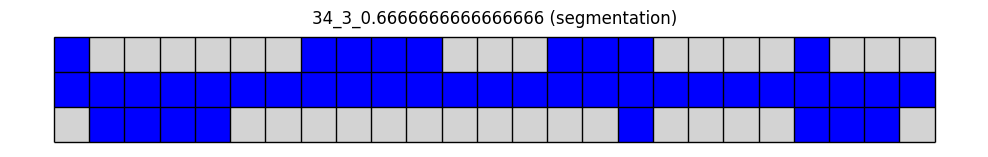

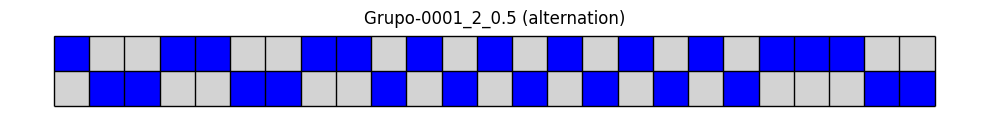

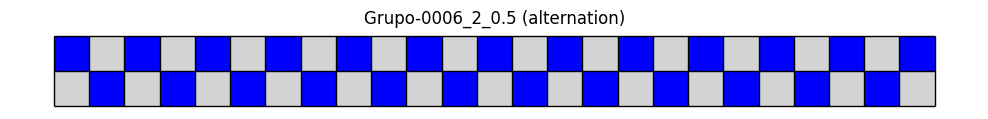

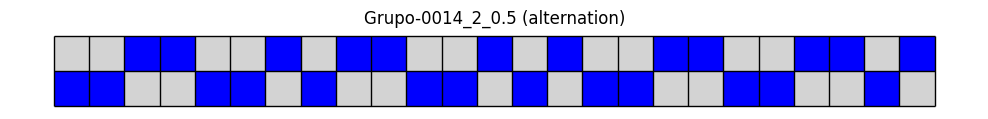

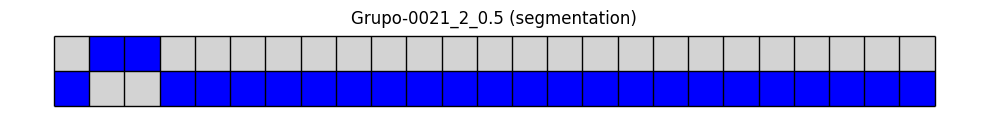

In [11]:
from Utils.bar_utils import BarRenderer

groups = df['model'].unique()
for group in groups:
    df_aux = data[data['model'] == group]
    df_aux_aux = df[df['model'] == group]
    threshold = df_aux_aux['threshold'].values[0]
    if threshold == 1:
        continue
    bar_renderer = BarRenderer(data=df_aux)
    bar_renderer.render(
        title=f"{group} ({df_aux_aux['category'].values[0]})",
        num_rounds=25
    )

### Most similar focal regions

In [5]:
sfr = SetFocalRegions(
    num_agents=5,
    threshold=0.8,
    len_history=5,
    max_regions=5,
    from_file=False
)
# sfr.focal_regions = sfr.load_focal_regions()
sfr.generate_focal_regions()
# idxs = [0, 1, 2, 3, 30, 31, 32, 33, 34, 35]
# sfr.focal_regions = list(np.array(sfr.focal_regions)[idxs])

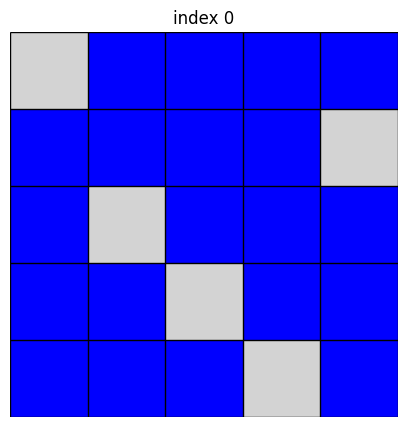

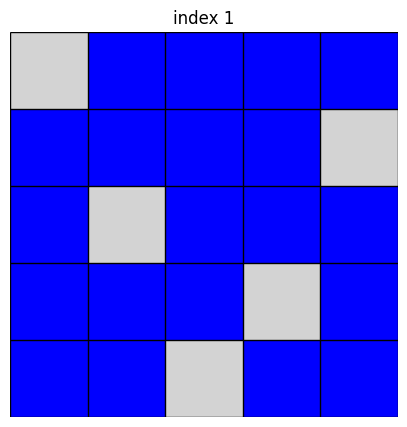

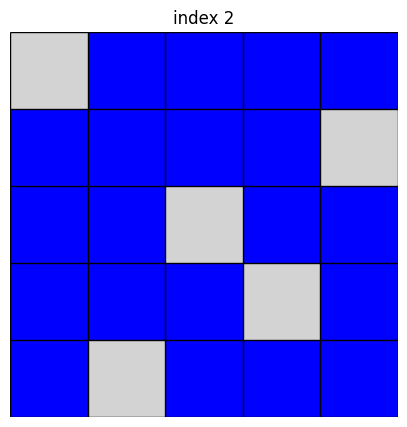

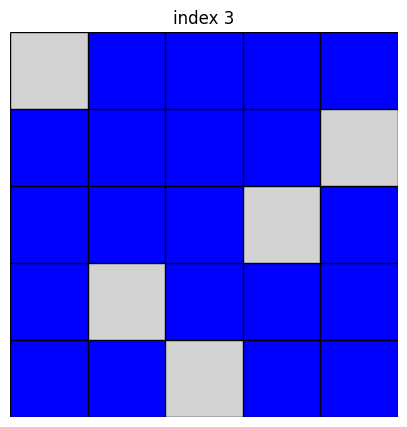

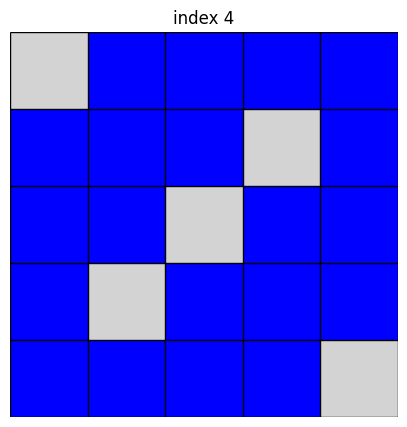

In [6]:
for i, region in enumerate(sfr.focal_regions):
    FocalRegion.draw_region(
        region=region.focal_region,
        title=f"index {i}"
    )


In [7]:
sfr.save_focal_regions()